In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами
import time # Импортируем библиотеку time
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки
from tensorflow.keras.callbacks import ModelCheckpoint # Для колбека

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #

import random #Для генерации случайных чисел 
import re #
%matplotlib inline

In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загружаем набор данных для обучения
df = pd.read_csv('/content/drive/MyDrive/Предобученные сети/Оренбургская область/train_dataset_train.csv')
# Загружаем набор данных для предсказания
df_test = pd.read_csv('/content/drive/MyDrive/Предобученные сети/Оренбургская область/test_dataset_test.csv')

In [ ]:
df.info() # Смотрим пропущенные значения и тип столбцов (обновлялся по мере обработки данных)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 58 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         200000 non-null  float64
 1   age_indicator              200000 non-null  float64
 2   month_id                   200000 non-null  float64
 3   student_id                 200000 non-null  float64
 4   program_id                 200000 non-null  float64
 5   spent_time_total           200000 non-null  float64
 6   spent_time_to_complete_hw  200000 non-null  float64
 7   completed_hw               200000 non-null  float64
 8   failed_hw                  200000 non-null  float64
 9   reworked_hw                200000 non-null  float64
 10  interacted_hw              200000 non-null  float64
 11  avg_hw_mark                200000 non-null  float64
 12  test_with_good_mark        200000 non-null  float64
 13  test_with_great_mark       20

In [ ]:
# Заменяем все пропуски на 0
df = df.fillna(0)

In [ ]:
# Убираем не нужные столбцы
df.drop(labels=['city', 'country', 'browser'], axis=1, inplace=True) #'country',

In [ ]:
# Меняем текстовые значения на цифровые
df = df.replace({'promo':{'+':0,'-':1},
                           'ABC':{'A':0, 'B':1, 'C':2, 'D':3},
                           'platform':{'pc':1, 'mobile':2, 'tablet':3},
                           'communication_type':{'web':1, 'order':2, 'phone':3},
                           'os':{'Windows':1, 'Mac OS X':2, 'iOS':3, 'Android':4,
                                 'Linux':5, 'Ubuntu':6, 'Chrome OS':7, 'Fedora':8}})


In [ ]:
# Заменяем последний день месяца среза на месяц
df['month_id'] = pd.DatetimeIndex(df['month_id']).month
# Разбирваем "дату создания заявки" на год, месяц, день
df['carts_created_at_day'] = pd.DatetimeIndex(df['carts_created_at']).day
df['carts_created_at_month'] = pd.DatetimeIndex(df['carts_created_at']).month
df['carts_created_at_year'] = pd.DatetimeIndex(df['carts_created_at']).year
df.drop(labels=['carts_created_at'], axis=1, inplace=True) # И убираем не нужный столбец


In [ ]:
# Переводим дата фрейм в один формат
df = df.astype('float64')#'int64'

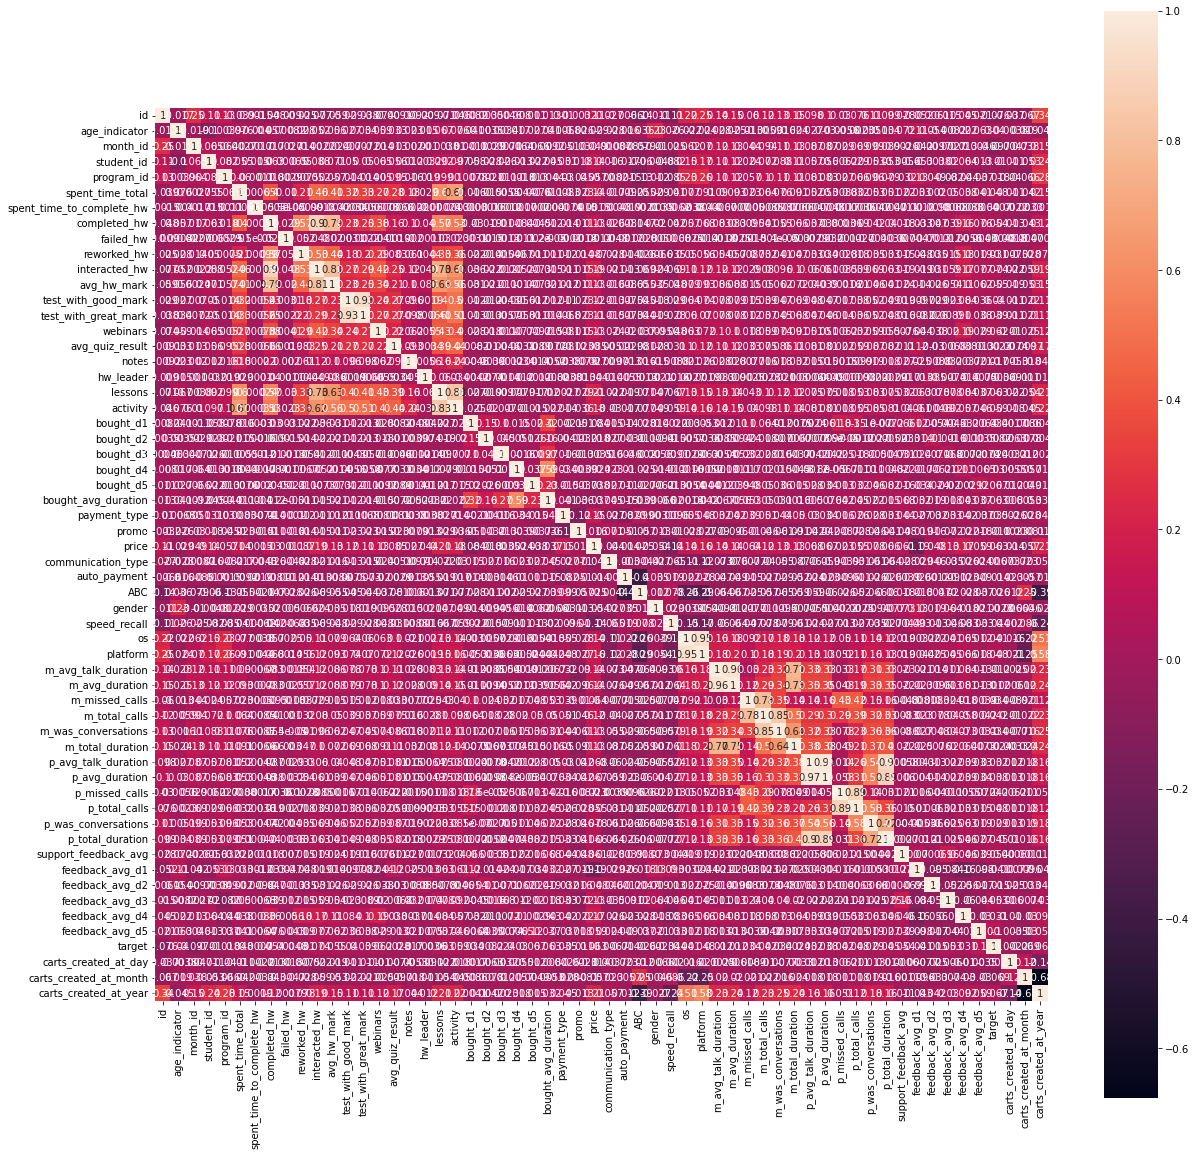

In [ ]:
# Посмотрим зависимости
plt.rcParams['figure.figsize']=(20,20)

g = sns.heatmap(df.corr(), square = True, annot=True)

In [ ]:
# Формируем данные для предсказания и категории предсказания
X = df.drop(labels=['target'], axis=1)
y = df[["target"]]

In [ ]:
# Делим данные на обучающию и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
'''
Сдесь записывалсь результаты экспеременнтов с подбором гипер параметров и предобработкой данных
'''
# 0.8023836722821466
#clf = RandomForestClassifier(n_estimators=50, max_features=30, max_depth=49) #max_depth=49 # random_state=0, n_estimators=50, max_features=30, max_depth=49,
# 0.8063817884974344
#clf = RandomForestClassifier(n_estimators=60, max_features=30, max_depth=49)
# 0.8087809067571984
# clf = RandomForestClassifier(n_estimators=60, max_features=40, max_depth=49)
# 0.8127026801898105
# clf = RandomForestClassifier(n_estimators=60, max_features=45, max_depth=49)

# При удалении столбцов 'city', 'country', 'browser' и оцифровки остального
# 0.8521345250692544
# clf = RandomForestClassifier(n_estimators=60, max_features=50, max_depth=49)
# 0.8534511112168865
# clf = RandomForestClassifier(n_estimators=60, max_features=56, max_depth=49)
# 0.853057864926767
# clf = RandomForestClassifier(n_estimators=60, max_features=56, max_depth=56, random_state=0)
# 0.8540719325775661
# clf = RandomForestClassifier(n_estimators=60, max_features=56, max_depth=56)

In [ ]:
clf = RandomForestClassifier(n_estimators=60, max_features=56, max_depth=56) # random_state=0, n_estimators=50, max_features=30, max_depth=49,

In [ ]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(max_depth=56, max_features=56, n_estimators=60)

In [ ]:
pred = clf.predict(X_test)

In [ ]:
0.2* recall_score(y_test, pred, average='macro') + 0.8* precision_score(y_test, pred, average='macro')

0.8498620030308354

# **Подготовка тестового датасета**

In [ ]:
# Загружаем набор данных для предсказания
df_test = pd.read_csv('/content/drive/MyDrive/Предобученные сети/Оренбургская область/test_dataset_test.csv')

In [ ]:
# Заменяем все пропуски на 0
df_test = df_test.fillna(0)

In [ ]:
# Убираем не нужные столбцы
df_test.drop(labels=['city', 'country', 'browser'], axis=1, inplace=True) #'country',

In [ ]:
# Меняем текстовые значения на цифровые
df_test = df_test.replace({'promo':{'+':0,'-':1},
                           'ABC':{'A':0, 'B':1, 'C':2, 'D':3},
                           'platform':{'pc':1, 'mobile':2, 'tablet':3},
                           'communication_type':{'web':1, 'order':2, 'phone':3},
                           'os':{'Windows':1, 'Mac OS X':2, 'iOS':3, 'Android':4,
                                 'Linux':5, 'Ubuntu':6, 'Chrome OS':7, 'Fedora':8}})

In [ ]:
# Заменяем последний день месяца среза на месяц
df_test['month_id'] = pd.DatetimeIndex(df_test['month_id']).month
# Разбирваем "дату создания заявки" на год, месяц, день
df_test['carts_created_at_day'] = pd.DatetimeIndex(df_test['carts_created_at']).day
df_test['carts_created_at_month'] = pd.DatetimeIndex(df_test['carts_created_at']).month
df_test['carts_created_at_year'] = pd.DatetimeIndex(df_test['carts_created_at']).year
df_test.drop(labels=['carts_created_at'], axis=1, inplace=True) # И убираем не нужный столбец

In [ ]:
# Переводим дата фрейм в один формат
df = df.astype('float64')

In [ ]:
pred_test = clf.predict(df_test)

In [ ]:
for i in range(len(df_test)): # Циклом проходимся по массиву
  df_test.loc[i,'target'] = pred_test[i] # Присваеваем категорию каждому обращению 
df_test = df_test.astype({'target':'Int64'}) # Переводим цифры в целочисленный формат
df_test # Смотрим что получилось

,id,age_indicator,month_id,student_id,program_id,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,...,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,carts_created_at_day,carts_created_at_month,carts_created_at_year,target
0,77551,0.0,5,7064806,1395,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,28,2,2021,0
1,227812,27.0,5,6982061,245,81.0,0.0,5.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2021,0
2,103035,9.0,6,7118790,1233,49.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,19,3,2021,0
3,260943,0.0,9,7288419,784,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29,6,2021,0
4,134611,7.0,8,6949976,998,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,31,12,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84992,186427,15.0,10,6841719,73,10.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,19,10,2021,0
84993,197918,27.0,11,6469768,885,27.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,7,11,2021,0
84994,174961,37.0,10,7328822,1126,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,7,2021,0
84995,182226,14.0,11,5255473,1495,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13,2,2021,0


In [ ]:
# Удаляем колонку с текстом 
df_test.drop(df_test.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                              21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
                              38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,
                              55,56]], axis=1, inplace=True)

In [ ]:
df_test

,id,target
0,77551,0
1,227812,0
2,103035,0
3,260943,0
4,134611,0
...,...,...
84992,186427,0
84993,197918,0
84994,174961,0
84995,182226,0


In [ ]:
# Сохраняем файл в формете .csv без индексов
df_test.to_csv('/content/drive/MyDrive/Предобученные сети/Оренбургская область/df_test_Netodologia_58_bas4-2.csv', index=False)

**Нейронка из полносвязных слоёв**

In [ ]:
dfX = df.drop(labels=['target'], axis=1)
dfY = df['target']

In [ ]:
df['target'].unique()

array([0, 3, 1, 4, 5, 2])

In [ ]:
x_train = np.array(dfX) # Преобразуем данные в numpy
y_train = np.array(dfY)# Преобразуем данные в numpy
print(x_train.shape)
print(y_train.shape)

(200000, 57)
(200000,)


In [ ]:
classes = list(df['target'].values) # Извлекаем соответствующие им значения классов (лейблов) столбца 'target'
nClasses = df['target'].nunique() # Задаём количество классов, обращаясь к столбцу 'Категория' и оставляя уникальные значения
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print('Посмотрим кодированные категории', encoder.classes_) # Посмотрим кодированные категории
print('Количество',classesEncoded.shape)
print('Посмотрим как выглядят первые 17 категорий', classesEncoded[:17])

yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 17, с 1кой в позиции соответствующего класса и нулями
print('Форма лейблов', yAll.shape) # Посмотрим на форму лейблов категорий
print('Первая строка лейблов',yAll[0]) # И отдельно на первую строку

Посмотрим кодированные категории [0 1 2 3 4 5]
Количество (200000,)
Посмотрим как выглядят первые 17 категорий [0 0 0 0 0 0 0 0 3 0 0 0 1 0 1 0 0]
Форма лейблов (200000, 6)
Первая строка лейблов [1. 0. 0. 0. 0. 0.]


In [ ]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(x_train, yAll, test_size=0.2, shuffle = True) # Берем 20% на тестовую выборку и перемешиваем данные
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(160000, 57)
(160000, 6)


Epoch 1/30
1334/1334 - 7s - loss: 7837.7114 - accuracy: 0.8164 - val_loss: 0.6460 - val_accuracy: 0.8723 - 7s/epoch - 5ms/step
Epoch 2/30
1334/1334 - 4s - loss: 29.9213 - accuracy: 0.8680 - val_loss: 0.5581 - val_accuracy: 0.8723 - 4s/epoch - 3ms/step
Epoch 3/30
1334/1334 - 5s - loss: 7.5893 - accuracy: 0.8702 - val_loss: 0.5507 - val_accuracy: 0.8723 - 5s/epoch - 3ms/step
Epoch 4/30
1334/1334 - 5s - loss: 4.1897 - accuracy: 0.8709 - val_loss: 0.5499 - val_accuracy: 0.8723 - 5s/epoch - 3ms/step
Epoch 5/30
1334/1334 - 4s - loss: 2.7485 - accuracy: 0.8709 - val_loss: 0.5498 - val_accuracy: 0.8723 - 4s/epoch - 3ms/step
Epoch 6/30
1334/1334 - 6s - loss: 1.5613 - accuracy: 0.8712 - val_loss: 0.5499 - val_accuracy: 0.8723 - 6s/epoch - 5ms/step
Epoch 7/30
1334/1334 - 5s - loss: 0.9704 - accuracy: 0.8712 - val_loss: 0.5499 - val_accuracy: 0.8723 - 5s/epoch - 3ms/step
Epoch 8/30
1334/1334 - 4s - loss: 1.1444 - accuracy: 0.8712 - val_loss: 0.5498 - val_accuracy: 0.8723 - 4s/epoch - 3ms/step
Epoc

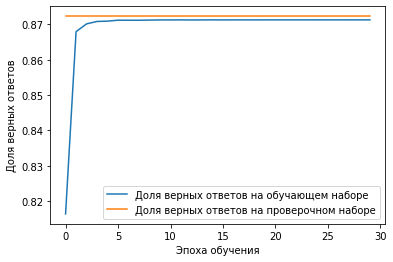

In [ ]:
model = Sequential()
#Входной полносвязный слой
model.add(Dense(100, input_dim=57, activation="relu"))
#Слой регуляризации Dropout
model.add(Dropout(0.2)) 
#Второй полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.3))
#Третий полносвязный слой
model.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.4))
#Выходной полносвязный слой
model.add(Dense(6, activation='softmax'))#softmax, sigmoid
time_start = [time.time()]

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=120,
                    validation_data=(xVal, yVal),
                    verbose=2) #callbacks=callbacks

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# **Предиктим тестовый датасет**

In [ ]:
# Загружаем тестовый датасет
df_test = pd.read_csv('/content/drive/MyDrive/Предобученные сети/Оренбургская область/test_dataset_test.csv')

In [ ]:
# Заменяем все пропуски на 0
df_test = df_test.fillna(0)

In [ ]:
# Убираем не нужные столбцы
df_test.drop(labels=['city', 'country', 'browser'], axis=1, inplace=True)

In [ ]:
# Меняем текстовые значения на цифровые
df_test = df_test.replace({'promo':{'+':0,'-':1},
                           'ABC':{'A':0, 'B':1, 'C':2, 'D':3},
                           'platform':{'pc':1, 'mobile':2, 'tablet':3},
                           'communication_type':{'web':1, 'order':2, 'phone':3},
                           'os':{'Windows':1, 'Mac OS X':2, 'iOS':3, 'Android':4,
                                 'Linux':5, 'Ubuntu':6, 'Chrome OS':7, 'Fedora':8}})

In [ ]:
# Заменяем последний день месяца среза на месяц
df_test['month_id'] = pd.DatetimeIndex(df_test['month_id']).month
# Разбирваем "дату создания заявки" на год, месяц, день
df_test['carts_created_at_day'] = pd.DatetimeIndex(df_test['carts_created_at']).day
df_test['carts_created_at_month'] = pd.DatetimeIndex(df_test['carts_created_at']).month
df_test['carts_created_at_year'] = pd.DatetimeIndex(df_test['carts_created_at']).year
df_test.drop(labels=['carts_created_at'], axis=1, inplace=True) # И убираем не нужный столбец

In [ ]:
# Переводим дата фрейм в один формат
df_test = df_test.astype('int64')

In [ ]:
x = np.array(df_test)

In [ ]:
prediction = model.predict(x)

In [ ]:
for i in range(len(x)): # Циклом проходимся по массиву
  df_test.loc[i,'target'] = np.argmax(prediction[i]) # Присваеваем категорию каждому обращению 
df_test = df_test.astype({'target':'Int64'}) # Переводим цифры в целочисленный формат
df_test # Смотрим что получилось

,id,age_indicator,month_id,student_id,program_id,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,...,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,carts_created_at_day,carts_created_at_month,carts_created_at_year,target
0,77551,0,5,7064806,1395,0,0,0,0,0,...,0,0,0,0,0,0,28,2,2021,0
1,227812,27,5,6982061,245,81,0,5,0,13,...,0,0,0,0,0,0,1,1,2021,0
2,103035,9,6,7118790,1233,49,0,2,0,0,...,0,0,0,5,0,0,19,3,2021,0
3,260943,0,9,7288419,784,10,0,0,0,0,...,0,0,0,0,0,0,29,6,2021,0
4,134611,7,8,6949976,998,0,0,0,0,0,...,0,0,0,0,0,0,31,12,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84992,186427,15,10,6841719,73,10,0,0,0,0,...,0,4,0,0,0,0,19,10,2021,0
84993,197918,27,11,6469768,885,27,0,0,0,0,...,0,0,0,4,0,0,7,11,2021,0
84994,174961,37,10,7328822,1126,0,0,1,0,0,...,0,0,0,0,0,0,5,7,2021,0
84995,182226,14,11,5255473,1495,0,0,0,0,0,...,0,0,0,0,0,0,13,2,2021,0


In [ ]:
# Удаляем колонку с текстом 
df_test.drop(df_test.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                              21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
                              38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,
                              55,56]], axis=1, inplace=True)

In [ ]:
df_test

,id,target
0,77551,0
1,227812,0
2,103035,0
3,260943,0
4,134611,0
...,...,...
84992,186427,0
84993,197918,0
84994,174961,0
84995,182226,0


In [ ]:
# Сохраняем файл в формете .csv без индексов
df_test.to_csv('/content/drive/MyDrive/Предобученные сети/Оренбургская область/df_test_Netodologia_57.csv', index=False)

 **Score =0.150176**
